In [4]:
#install.packages("readxl")
library(tidyverse)
library(rvest)
library(readxl)

── Attaching packages ─────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




In [121]:
#first we get all xlsx file links from url
mental_health_data_urls_all_years <- 'https://www.health.govt.nz/our-work/mental-health-and-addiction/mental-health-and-addiction-monitoring-reporting-and-data' %>% 
                                        read_html() %>%
                                        html_element('#node-12245 > div > div > div > ul:nth-child(19)') %>%
                                        html_elements("a") %>%
                                        html_attrs() %>% 
                                        str_c('https://www.health.govt.nz/', .)

#function is to download xlsx from health url 
download_xlsx_file <- function(heath_url, file_name){
                        download_ur <- heath_url %>% 
                            read_html() %>%
                            html_element("#block-system-main > div > div:nth-child(2) > div.panel-panel.right.col-xs-12.col-sm-12.col-md-3.col-lg-3 > div.panel-pane.pane-views.pane-file-attachments-revisioning.pane-downloads-right.standard-block.even.hidden-xs.hidden-sm > div > div > div > div > ul > li > span > a") %>% 
                            html_attr("href") 
                        download.file(url = download_ur, destfile = file_name)
}


build_sheet_name <- function(str1, str2, separator){
    data <- paste(str1, str2, sep=separator)
    return(data)
}

get_sheet_separator <- function(file_name){
    sheets <- file_name %>% excel_sheets()
    if ('table1,2' %in% sheets){
        separator <- ','
    }else{
        separator <- '&'
    }
}


#iteral through every year from 2014 to 2019
file_metadata_df <- data.frame(year=double(),
                               file_name=character(),
                               url=character(),
                               separator=character())

start_year = 2014

for (url_yearly_health in mental_health_data_urls_all_years){
    file_name = str_c('mental_health', start_year) %>% 
                    str_c('.xlsx')
    start_year = start_year + 1
    download_xlsx_file(url_yearly_health, file_name)
    separator <- get_sheet_separator(file_name)
    file_metadata_df <- file_metadata_df %>% add_row(year=start_year,
                                                 file_name=file_name,
                                                 url=url_yearly_health,
                                                 separator=separator)
}
file_metadata_df


year,file_name,url,separator
<dbl>,<chr>,<chr>,<chr>
2015,mental_health2014.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2019-20-tables,","
2016,mental_health2015.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2018-19-tables,","
2017,mental_health2016.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2017-18-tables,","
2018,mental_health2017.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables,","
2019,mental_health2018.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables,","
2020,mental_health2019.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2014-15,&
2021,mental_health2020.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2013-14,&


In [116]:
#get all col names for table use after
#get metadata from one of the files.
first_file = file_metadata_df[1,]

age_group_col_names <-  first_file$file_name %>% read_excel(sheet = build_sheet_name('table1', '2', first_file$separator),
                                                            range = cell_rows(4:4)) %>% colnames()
add_sex_totl_age_group_col_names <- c('gender', "Total", age_group_col_names)


table_1_2_positions <- tibble(ethnic_group=c('Maori', 'Pacific', 'Asian', 'Other'),
                              range=c('B9:U10', 'B12:U13', 'B15:U16', 'B18:U19'))



table_1_2_positions

ethnic_group,range
<chr>,<chr>
Maori,B9:U10
Pacific,B12:U13
Asian,B15:U16
Other,B18:U19


In [156]:
#two different way get first table of total group data

clients_by_age_ethnic_group_df <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer() 
                                         ) 


get_clients_by_gender_ethnic_group <- function(file_metadata, columns){

    clients_by_age_ethnic_group <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer()) 
    
    for (i in 1:nrow(table_1_2_positions)) {
        row <- table_1_2_positions[i,]
        ethnic_group_df <- file_metadata$file_name %>% read_excel(sheet=build_sheet_name("table1", "2", file_metadata$separator),
                                                       range = row$range,
                                                       col_names = add_sex_totl_age_group_col_names) #range = cell_rows(3:19), 
        ethnic_group_df <- ethnic_group_df %>% add_column(ethnic_group=row$ethnic_group, year=file_metadata$year)
        ethnic_group_df <- ethnic_group_df %>% select(-Total)
        long_col_name <- ethnic_group_df %>% select(ends_with("-"), ends_with('+')) %>% names()
        clients_by_age_ethnic_group <- clients_by_age_ethnic_group %>% 
                                       add_row(ethnic_group_df %>% 
                                       gather(age_group, amount, long_col_name, factor_key=TRUE))
    }  
    return(clients_by_age_ethnic_group)
}

get_all_year_clients_by_gender_ethnic_group <- function(){
    for (i in 1:nrow(file_metadata_df)){
        row <- file_metadata_df[i,]
        clients_by_age_ethnic_group_df <- clients_by_age_ethnic_group_df %>% add_row(get_clients_by_gender_ethnic_group(row, add_sex_totl_age_group_col_names))
    }
    return(clients_by_age_ethnic_group_df) 
    
}


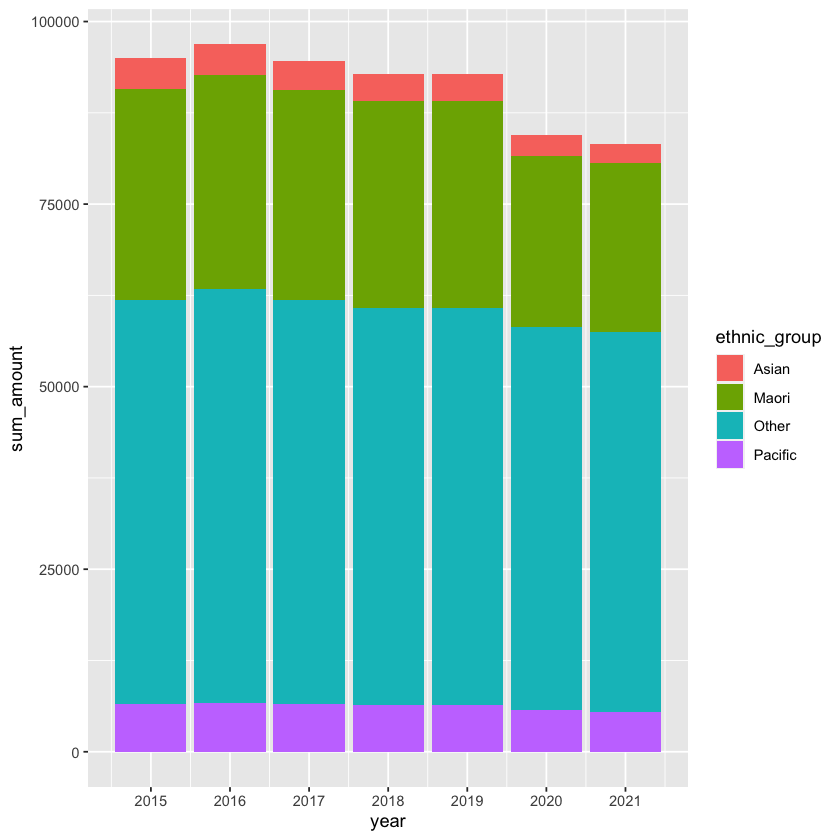

In [157]:
years <- full_clients_by_gender_ethnic_df %>% select(year) %>% distinct()
full_clients_by_gender_ethnic_df %>% filter(gender=='Male') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

In [ ]:
full_clients_by_gender_ethnic_df %>% filter(gender=='Male') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

In [68]:
#first table, maori df
df_maori_first_table <- all_data[5:7,2:21]
colnames(df_maori_first_table) <- add_sex_totl_age_group_col_names 
#first table, Pacific df
df_Pacific_first_table <- all_data[8:10,2:21]
colnames(df_Pacific_first_table) <- add_sex_totl_age_group_col_names 
#first table, Asian df
df_Asian_first_table <- all_data[11:13,2:21]
colnames(df_Asian_first_table) <- add_sex_totl_age_group_col_names 
#first table, other df
df_other_first_table <- all_data[14:16,2:21]
colnames(df_other_first_table) <- add_sex_totl_age_group_col_names 

# df_Pacific_first_table
# df_maori_first_table
# df_Asian_first_table
# df_other_first_table

In [69]:
#table name for rate df
add_sex_rate_age_group_col_names <- c('sex', "Crude_rate", age_group_col_names, 'ASR')

In [70]:
#second table tolal df
df_other_second_table <- all_data[24:26,2:22]
colnames(df_other_second_table) <- add_sex_rate_age_group_col_names 

#second table, maori df
df_maori_second_table <- all_data[27:29,2:22]
colnames(df_maori_second_table) <- add_sex_rate_age_group_col_names 
#second table, Pacific df
df_Pacific_second_table <- all_data[30:32,2:22]
colnames(df_Pacific_second_table) <- add_sex_rate_age_group_col_names 
#second table, Asian df
df_Asian_second_table <- all_data[33:35,2:22]
colnames(df_Asian_second_table) <- add_sex_rate_age_group_col_names 
#second table, other df
df_other_second_table <- all_data[36:38,2:22]
colnames(df_other_second_table) <- add_sex_rate_age_group_col_names 

 df_other_second_table
# df_maori_second_table
# df_Pacific_second_table
# df_Asian_second_table
# df_other_second_table

sex,Crude_rate,0-,5-,10-,15-,20-,25-,30-,35-,⋯,45-,50-,55-,60-,65-,70-,75-,80-,85+,ASR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Total,3469.7,529.79999999999995,2710,4932.2,7175.5,5284.1,4861.7,4747.7,4390.1000000000004,⋯,3481.6,2987.9,2446,1939.1,1622.3,1772.9,2268.9,2953.3,3540.2,3795.1
Male,3589.8,671.8,3635,4824.3999999999996,6233.5,5549,5074.7,4888.8999999999996,4756.6000000000004,⋯,3800.9,3206.5,2611,1955.7,1477.6,1632.9,2052,2654.7,3558.5,3926.8
Female,3354.1,380.8,1740.3,5044.8,8170.6,5009,4647,4614,4050.4,⋯,3178.1,2777.4,2285.5,1923.1,1762,1904.8,2459.3000000000002,3190.4,3529.8,3667.5
